In [7]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from river.decomposition import OnlineDMD
from tqdm import tqdm

sys.path.append("../")

from functions.chdsubid import (
    SubIDChangeDetector,
    get_default_params,
)
from functions.datasets import load_skab
from functions.metrics import chp_score
from functions.preprocessing import Hankelizer
from functions.rolling import Rolling

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
# Read data
dfs = load_skab("data/skab")
dfs_free = [
    df
    for key, df_group in dfs.items()
    for df in df_group
    if key == "anomaly-free"
]
dfs_: list[pd.DataFrame] = [
    pd.DataFrame(df)
    for key, df_group in dfs.items()
    for df in df_group
    if key != "anomaly-free"
]
for df in dfs_:
    df.index = pd.to_datetime(df.index)

In [34]:
# Prepare arrays for storing results
scores_datasets = []
scores_datasets_alt = []

grace_period = 400  # Used in SKAB Leaderboard

# Iterate datasets
for i, df in enumerate(dfs_):
    X = df.drop(["anomaly", "changepoint"], axis=1)
    from sklearn.model_selection import train_test_split

    X_train, X_test = train_test_split(
        X, train_size=grace_period, shuffle=False
    )

    window_size = grace_period
    hn, ref_size, test_size, r = get_default_params(
        X, grace_period // 2
    )  # Anomalies take 5 minutes sampling is 1 second
    hn = 15
    r = 2
    ref_size = 300
    test_size = 60
    # Initialize Hankelizer
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    init_size = grace_period - test_size - 1
    odmd = Rolling(
        OnlineDMD(
            r=r,
            initialize=init_size,
            w=1.0,
            exponential_weighting=True,
            eig_rtol=1e-1,
        ),
        grace_period,
    )

    # Initialize Change-Point Detector
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=grace_period,
        threshold=0.001,  # df.std().mean() / 100,
        learn_after_grace=False,
        start_soon="soon",
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    for x in X_train.to_dict(orient="records"):
        pipeline_dmd.learn_one(x)
    # Produces scaled results
    # pipeline_dmd.learn_many(X_train)

    scores_dmd = np.zeros(X_test.shape[0], dtype=float)
    scores_dmd_alt = np.zeros(X_test.shape[0], dtype=float)
    # Run pipeline
    for j, x in tqdm(
        enumerate(X_test.to_dict(orient="records")),
        total=len(X_test),
        mininterval=1.0,
        desc=f"Dataset: {i+1}/{len(dfs_)}. Snapshots processed",
    ):
        scores_dmd[j] = pipeline_dmd.score_one(x)
        # Although learn one is present, the DMD is not learning from the data
        #  as learn_after_grace=False. Nevertheless the data collection mechanism
        #  is still active and needs to be updated.
        pipeline_dmd.learn_one(x)

        dist = subid_dmd.distances
        scores_dmd_alt[j] = (dist[1] - dist[0]).real

    scores_datasets.append(pd.Series(scores_dmd, index=X_test.index))
    scores_datasets_alt.append(pd.Series(scores_dmd_alt, index=X_test.index))

with open("results/.skab/skab_scores_datasets-online.pkl", "wb") as f:
    pickle.dump(scores_datasets, f)

Dataset: 34/34. Snapshots processed: 100%|██████████| 729/729 [00:02<00:00, 304.57it/s]


In [35]:
true_outlier, true_cp = [], []
# Iterate datasets
for i, df in enumerate(dfs_):
    Y = df[["anomaly", "changepoint"]]
    from sklearn.model_selection import train_test_split

    Y_train, Y_test = train_test_split(
        Y, train_size=grace_period, shuffle=False
    )
    true_outlier.append(Y_test["anomaly"])
    true_cp.append(Y_test["changepoint"])
if "scores_datasets" not in locals():
    with open("results/.skab/skab_scores_datasets-online.pkl", "rb") as f:
        scores_datasets = pickle.load(f)

In [61]:
score_params = {
    "valid": [
        {"metric": "binary"},
        {
            "metric": "average_time",
            "window_width": "30s",
            "anomaly_window_destination": "center",
        },
        {
            "metric": "nab",
            "window_width": "30s",
            "anomaly_window_destination": "center",
        },
    ],
    "compiant": [
        {"metric": "binary"},
        {
            "metric": "average_time",
            "window_width": "60s",
            "anomaly_window_destination": "righter",
        },
        {
            "metric": "nab",
            "window_width": "60s",
            "anomaly_window_destination": "righter",
        },
    ],
}

In [92]:
experiments: dict[str, list] = {
    "Perfect detector": true_outlier,
    "Random detector": [
        pd.Series(np.random.randint(2, size=df.shape[0]), index=df.index)
        for df in dfs_
    ],
    "Null detector": [
        pd.Series(np.zeros(df.shape[0]), index=df.index) for df in dfs_
    ],
    "Always positive": [
        pd.Series(np.ones(df.shape[0]), index=df.index) for df in dfs_
    ],
    "Online DMD (t=0)": [sd > 0.0 for sd in scores_datasets],
    "Online DMD (alt) (t=0)": [sd > 0.0 for sd in scores_datasets_alt],
    "Online DMD": [sd > 0.0025 for sd in scores_datasets],
    "Online DMD (alt)": [sd > 250 for sd in scores_datasets_alt],
}

window_params = {
    "valid": {
        "window_width": "30s",
        "anomaly_window_destination": "center",
    },
    "compiant": {
        "window_width": "60s",
        "anomaly_window_destination": "righter",
    },
}

metrics = [
    "F1",
    "FAR",
    "MAR",
    "Delay",
    "TP",
    "FN",
    "FP",
    "Standard",
    "LowFP",
    "LowFN",
]

df_res = pd.DataFrame(
    columns=[f"{m} ({p})" for p in score_params for m in metrics],
    index=list(experiments.keys()),
)

for name, pos in experiments.items():
    pcs = [po.astype(int).diff().abs().fillna(0.0) for po in pos]
    res = {}
    for window_name, kwargs in window_params.items():
        binary = chp_score(
            true_outlier,
            pos,
            metric="binary",
        )
        add = chp_score(
            true_cp,
            pcs,
            metric="average_time",
            window_width=kwargs["window_width"],
            anomaly_window_destination=kwargs["anomaly_window_destination"],
        )
        nab = chp_score(
            true_cp,
            pcs,
            metric="nab",
            window_width=kwargs["window_width"],
            anomaly_window_destination=kwargs["anomaly_window_destination"],
        )
        res_ = dict(zip(["F1", "FAR", "MAR"], binary))
        res_.update(dict(zip(["Delay", "TP", "FN", "FP"], add)))
        res_.update(nab)
        res_ = {f"{k} ({window_name})": v for k, v in res_.items()}
        res.update(res_)
    df_res.loc[name] = res

df_res

/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/mw/pyprojects/odmd-subid-cpd/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mw/pyprojects/odmd-subid-cpd/.

,F1 (valid),FAR (valid),MAR (valid),Delay (valid),TP (valid),FN (valid),FP (valid),Standard (valid),LowFP (valid),LowFN (valid),F1 (compiant),FAR (compiant),MAR (compiant),Delay (compiant),TP (compiant),FN (compiant),FP (compiant),Standard (compiant),LowFP (compiant),LowFN (compiant)
Perfect detector,1.0,0.0,0.0,-1 days +23:59:59.953846154,62,0,127,37.07,35.67,41.77,1.0,0.0,0.0,0 days 00:00:11.782051282,49,0,127,54.77,54.11,56.99
Random detector,0.51,49.61,51.43,-1 days +23:59:47.003937008,0,16928,127,-635.5,-1368.84,-390.33,0.51,49.61,51.43,0 days 00:00:01.015748031,0,15300,127,-564.02,-1226.76,-342.68
Null detector,0.0,0.0,100.0,NaN,127.0,0.0,127.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,127.0,0.0,127.0,0.0,0.0,0.0
Always positive,0.7,100.0,0.0,NaN,127.0,0.0,127.0,0.0,0.0,0.0,0.7,100.0,0.0,NaN,127.0,0.0,127.0,0.0,0.0,0.0
Online DMD (t=0),0.47,51.05,55.84,-1 days +23:59:58.952380953,85,308,127,11.16,-3.03,18.46,0.47,51.05,55.84,0 days 00:00:24.820895522,60,254,127,29.68,17.48,37.37
Online DMD (alt) (t=0),0.47,51.05,55.84,-1 days +23:59:58.952380953,85,308,127,11.16,-3.03,18.46,0.47,51.05,55.84,0 days 00:00:24.820895522,60,254,127,29.68,17.48,37.37
Online DMD,0.43,41.16,63.19,0 days 00:00:01.128205128,88,285,127,9.32,-3.92,16.45,0.43,41.16,63.19,0 days 00:00:24.098360655,66,240,127,27.35,15.93,34.24
Online DMD (alt),0.47,49.99,56.49,-1 days +23:59:58.837209303,84,308,127,11.84,-2.36,19.18,0.47,49.99,56.49,0 days 00:00:24.164179104,60,250,127,30.29,18.31,37.78


# Visualize results

In [42]:
def plot_results(
    *true_pred_pairs: tuple[pd.Series, pd.Series], reset_index: bool = False
):
    n = len(true_pred_pairs)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3 * n))
    if n == 1:
        axs = [axs]

    for ax, (true, pred) in zip(axs, true_pred_pairs):
        if reset_index:
            true = true.reset_index(drop=True)
            pred = pred.reset_index(drop=True)
        ax.plot(true, label="True", marker="o", markersize=5)
        axx = ax.twinx()
        axx.plot(
            pred,
            label="Predicted",
            marker="x",
            markersize=5,
            color=ax._get_lines.get_next_color(),
        )
        ax.grid()

In [ ]:
# [donotremove]
plot_results(*list(zip(*(true_outlier, pos))))

In [ ]:
# [donotremove]
plot_results(*list(zip(*(true_cp, pcs))))

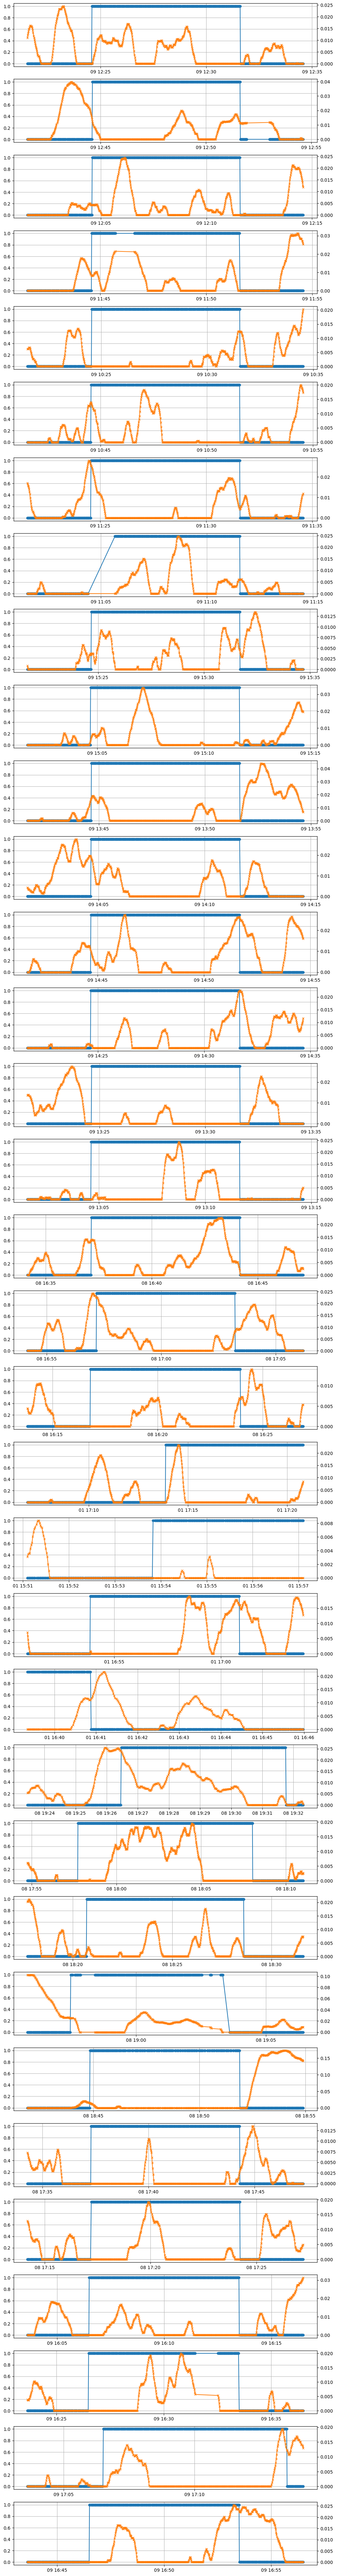

In [43]:
# [donotremove]
plot_results(*list(zip(*(true_outlier, scores_datasets))))